# Introduction

We begin by importing OpenEO and choosing a timespan with two images. We then want to proceed and remove different dimensions.

In [1]:
import openeo
import numpy as np
from config import user,passwd,eo_service_url
from demo_regions import s2
from demo_helpers import show_result


In [2]:
connection = openeo.connect(eo_service_url)

In [3]:
s2_datacube=connection.load_collection(collection_id=s2.s2_msi_l2a,
                         spatial_extent=s2.bbox.karlstad_mini_land,
                         temporal_extent=s2.timespans.two_images,
                        bands=['b08','b04'],
                        )

{'loadcollection1': {'process_id': 'load_collection', 'arguments': {'bands': ['b08', 'b04'], 'id': 's2_msi_l2a', 'spatial_extent': {'west': 13.460930954751282, 'east': 13.585449709728213, 'south': 59.36327761288911, 'north': 59.40107161575003}, 'temporal_extent': ['2021-11-30T00:00:00Z', '2021-12-03T00:00:00Z']}, 'result': True}}


[<open DatasetReader name='/var/folders/z8/rlxnx8ys0plf685w66sqlrtw0000gq/T/tmpr07dl0_k/a822e045-8047-4566-8e1b-0278cb8ac476/out_2021_11_30T10_33_09.tif' mode='r'>,
 <open DatasetReader name='/var/folders/z8/rlxnx8ys0plf685w66sqlrtw0000gq/T/tmpr07dl0_k/a822e045-8047-4566-8e1b-0278cb8ac476/out_2021_12_02T10_24_01.tif' mode='r'>]

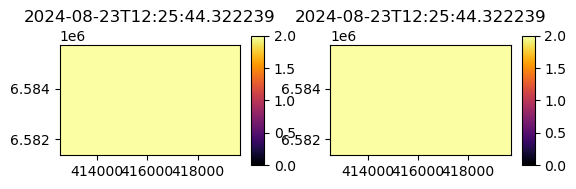

In [4]:
# Show information
print(s2_datacube.flat_graph())
s2_image_data = s2_datacube.download(format="gtiff")
show_result(s2_image_data)

# Reduction

Reductions in OpenEO are operations that reduce the dimensionality of the data. The `reduce_dimension` process collapses a whole dimension of the datacube. It does so by using some sort of reducer, which is a function that calculates a single result from an amount of values, as e.g. mean(), min() and max() which is calculated over a specified dimension (e.g., time, bands).

![reduction](https://openeo.org/assets/img/dc_reduce.872f16c2.png)

Figure: Overview of reducing the sample datacube. Dimensions that are reduced are crossed out in the result images. Their information value has been compressed by a reducer function. Our timespan is:

In [5]:
s2.timespans.two_images

['2021-11-30T00:00:00Z', '2021-12-03T00:00:00Z']

If we reduce the time and take the minimum we should only get the first image.

{'loadcollection1': {'process_id': 'load_collection', 'arguments': {'bands': ['b08', 'b04'], 'id': 's2_msi_l2a', 'spatial_extent': {'west': 13.460930954751282, 'east': 13.585449709728213, 'south': 59.36327761288911, 'north': 59.40107161575003}, 'temporal_extent': ['2021-11-30T00:00:00Z', '2021-12-03T00:00:00Z']}}, 'reducedimension1': {'process_id': 'reduce_dimension', 'arguments': {'data': {'from_node': 'loadcollection1'}, 'dimension': 't', 'reducer': {'process_graph': {'min1': {'process_id': 'min', 'arguments': {'data': {'from_parameter': 'data'}}, 'result': True}}}}, 'result': True}}


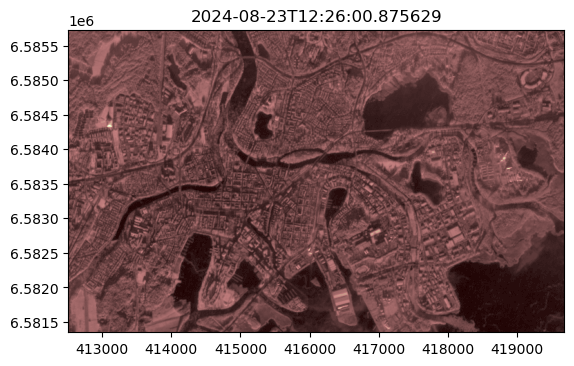

In [6]:
reduced_cube_over_time = s2_datacube.reduce_dimension(dimension="t", reducer="min")

# Show information
print(reduced_cube_over_time.flat_graph())
s2_image_data_reduced = reduced_cube_over_time.download(format="gtiff")
results_time_reduce=show_result(s2_image_data_reduced)

Let's check our results:

In [7]:
print("We expect a single raster to look at, number of rasters is:", len(results_time_reduce))
print("We should have multiple bands in the metadata, check the index:", results_time_reduce[0].indexes) 

We expect a single raster to look at, number of rasters is: 1
We should have multiple bands in the metadata, check the index: (1, 2)


Let's try to reduce the dimension over the bands instead. In this example we choose the mean. This means that we will take the mean of the two bands that we have available for each day.

{'loadcollection1': {'process_id': 'load_collection', 'arguments': {'bands': ['b08', 'b04'], 'id': 's2_msi_l2a', 'spatial_extent': {'west': 13.460930954751282, 'east': 13.585449709728213, 'south': 59.36327761288911, 'north': 59.40107161575003}, 'temporal_extent': ['2021-11-30T00:00:00Z', '2021-12-03T00:00:00Z']}}, 'reducedimension1': {'process_id': 'reduce_dimension', 'arguments': {'data': {'from_node': 'loadcollection1'}, 'dimension': 'bands', 'reducer': {'process_graph': {'mean1': {'process_id': 'mean', 'arguments': {'data': {'from_parameter': 'data'}}, 'result': True}}}}, 'result': True}}


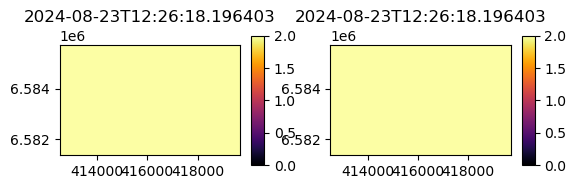

In [8]:
import rasterio
import io
reduced_cube_over_bands = s2_datacube.reduce_dimension(dimension="bands", reducer="mean")

# Show information
print(reduced_cube_over_bands.flat_graph())
# reduced_cube_over_bands.metadata
s2_image_data_reduced = reduced_cube_over_bands.download(format="gtiff")
results_bands_reduce=show_result(s2_image_data_reduced)

In [9]:
print("We expect multiple rasters to look at, number of rasters is:", len(results_bands_reduce))
print("We should have multiple a single band in the metadata, check the index:", results_bands_reduce[0].indexes) 

We expect multiple rasters to look at, number of rasters is: 2
We should have multiple a single band in the metadata, check the index: (1,)


We can also check if the calculation is correct. We first calculate the mean of the bands of the first pixel from the first image:

In [10]:
np.mean([results_time_reduce[0].read(1)[0,0], results_time_reduce[0].read(2)[0,0]])

1691.0

We compare it with the value of the single band in the first picture in the band reduce result:

In [11]:
results_bands_reduce[0].read(1)[0,0]

1691.0

Calculation was successful!